In [160]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from model_builder import stationarity_test
from criteria_housing import name_zipcode_area
from model_builder import dataframe_cleaner
from model_builder import model
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
#loading all zipcodes pandas dataframes
zillow_df = pd.read_csv('../write_data/zipcodes_all_price.csv',
                        index_col = 0, parse_dates = True)
zillow_df.columns = pd.to_numeric(zillow_df.columns)

# loading top 100 ROI zipcodes pandas dataframes
top_df = pd.read_csv('../write_data/top_monthly.csv', 
                     index_col = 0, parse_dates = True)
top_df.columns = pd.to_numeric(top_df.columns)

# loading bottom 100 ROI zipcodes pandas dataframes
bottom_df = pd.read_csv('../write_data/bottom_monthly.csv', 
                        index_col = 0, parse_dates = True)
bottom_df.columns = pd.to_numeric(bottom_df.columns)

# loading random 100 ROI zipcodes pandas dataframes
random_df = pd.read_csv('../write_data/random_monthly.csv', 
                        index_col = 0, parse_dates = True)
random_df.columns = pd.to_numeric(random_df.columns)

In [168]:
zillow_df.head()

,60657,75070,77494,60614,79936,77084,10467,60640,77449,94109,...,3765,84781,12429,97028,12720,1338,3293,40404,81225,89155
Date_index,,,,,,,,,,,,,,,,,,,,,
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0


In [176]:
#filtering out dataframes with null values
print('old top_df containing null columns:', len([col for col in top_df if top_df[col].isnull().sum()>0]))
top_df = dataframe_cleaner(top_df)
print('cleaned top_df containing null columns:', len([col for col in top_df if top_df[col].isnull().sum()>0]) )

old top_df containing null columns: 18
cleaned top_df containing null columns: 0


In [177]:
#filtering out random and bottom dataframes with null values
bottom_df = dataframe_cleaner(bottom_df)
random_df = dataframe_cleaner(random_df)

In [6]:
#loading state, county and region details for our data
region_df = pd.read_csv('../write_data/regions_zipcode.csv', index_col=0)

name_zipcode_area(region_df, topfive_zipcodes)

,RegionID,RegionName,City,State,Metro,CountyName
4211,60610,7106,Newark,NJ,New York,Essex
10069,70641,29661,Marietta,SC,Greenville,Greenville
6216,86349,64110,Kansas City,MO,Kansas City,Jackson
14244,66512,20621,Chaptico,MD,California-Lexington Park,Saint Marys
3540,60607,7103,Newark,NJ,New York,Essex


* **Checking for stationarity of data before building models**

* **Finding autoregressive order p using autocorrelation**

In [192]:
top_df.head()

,7106,29661,64110,20621,7103,18346,60954,34785,18224,17931,...,8270,18651,65723,14572,7002,14809,18355,12528,28786,14062
Date_index,,,,,,,,,,,,,,,,,,,,,
1996-04-01,91400.0,56500.0,59200.0,94300.0,78000.0,53600.0,78400.0,46400.0,41100.0,36700.0,...,93100.0,45400.0,29900.0,52200.0,145000.0,45900.0,60900.0,107600.0,48900.0,62800.0
1996-05-01,91300.0,56800.0,59500.0,95200.0,78100.0,53800.0,78300.0,46300.0,40900.0,36800.0,...,93300.0,45300.0,30300.0,52300.0,144500.0,45900.0,61000.0,107400.0,48900.0,62600.0
1996-06-01,91200.0,57200.0,59700.0,96000.0,78200.0,53900.0,78000.0,46200.0,40600.0,36800.0,...,93500.0,45200.0,30600.0,52400.0,143900.0,45800.0,61000.0,107300.0,48800.0,62500.0
1996-07-01,91200.0,57600.0,59900.0,96900.0,78300.0,54100.0,77900.0,46100.0,40400.0,36800.0,...,93600.0,45100.0,30900.0,52500.0,143300.0,45700.0,61100.0,107100.0,48500.0,62300.0
1996-08-01,91200.0,58000.0,60200.0,97700.0,78300.0,54200.0,77800.0,46000.0,40200.0,36800.0,...,93800.0,45000.0,31300.0,52500.0,142800.0,45700.0,61100.0,107000.0,48200.0,62100.0


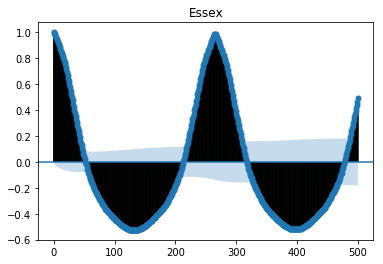

In [7]:
## value greater than 
plot_acf(topfive_df[7106], lags=500, alpha=0.05, title = 'Essex')
plt.show()
# for col in topfive_df:
#     plot_acf(topfive_df[col], lags=50, alpha=0.05, title=f'{col}')

* **This sequence is repeating every twenty years**

In [8]:
#auto correlation function. A value greater than 0.05 is a viable AR order p
acf(topfive_df[7106], nlags=50)[:5]

array([1.        , 0.99324043, 0.98441982, 0.9742717 , 0.96320004])

* **Finding moving average order q using partial autocorrelation**

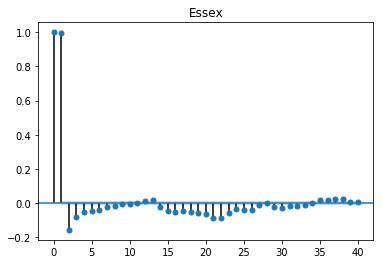

In [9]:
#partial autocorrelation function. A value greater than 0.05 is a viable MA order q
plot_pacf(topfive_df[7106], lags=40, alpha=0.05, title = 'Essex');

* **since the diff() made the data stationary, the integrated d is 1.**

In [211]:
#picking top zipcodes
model_topzipcodes = top_df.columns[:6]
model_topzipcodes

Int64Index([7106, 29661, 64110, 20621, 7103, 18346], dtype='int64')

In [199]:
# df = zillow_df[20621].diff().dropna().values
# model_params = []

# for p in range(1,3):
#         for q in range(1,3):
#             test_model = ARIMA(df, (p,0,q)).fit()
#             test_bic = test_model.bic
#             model_params.append((p, q, test_model, test_bic))


In [201]:
# model_params[1][2].plot_predict(1, 300);

In [264]:
stationarydata = zillow_df[95008].diff().dropna().values
model_params = {}
lowest_bic = None
count = 0
for p in range(1, 8):
    for q in range(1,10):
        count+=1
        test_model = ARIMA(stationarydata, (p,1,q)).fit()
        test_bic = test_model.bic
       
        if lowest_bic is None:
            lowest_bic = test_bic
        elif lowest_bic > test_bic:
            lowest_bic = test_bic
            
            model_params['lowest_bic'] = lowest_bic
            model_params['p'] = p
            model_params['q'] = q
            model_params['test_model'] = test_model
        else:
            break   

//anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [346]:
santadata = zillow_df[95008].diff().dropna().values
santa_model = ARIMA(santadata, (1,1,3)).fit()
santa_forecast = santa_model.forecast(264)

//anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [358]:
len(santa_forecast[2])

264

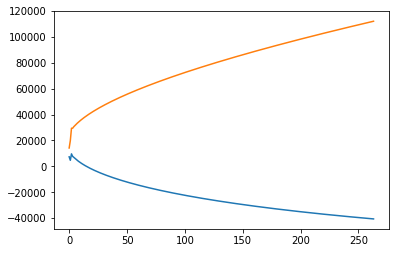

In [361]:
plt.plot(santa_forecast[2]);

(0.0, 262.0)

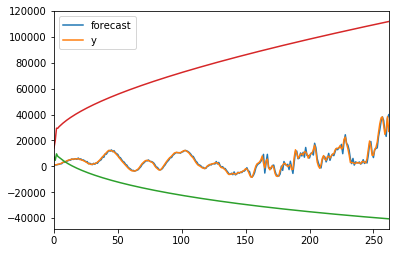

In [362]:
santa_model.plot_predict()
plt.plot(santa_forecast[2])

#plt.plot(zillow_df[95008].diff().dropna().values)
plt.xlim()

In [330]:
santa_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -2340.199
Method:                       css-mle   S.D. of innovations           1739.079
Date:                Thu, 03 Oct 2019   AIC                           4692.398
Time:                        16:22:00   BIC                           4713.831
Sample:                             1   HQIC                          4701.011
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.4877    147.848      0.443      0.658    -224.289     355.265
ar.L1.D.y     -0.1445      0.100     -1.443      0.150      -0.341       0.052
ma.L1.D.y      1.1368      0.080     14.152      0.000       0.979       1.294
ma.L2.D.y      0.0126      0.132      0.096      0.924      -0.245       0.271
ma.L3.D.y     -0.5763      0.078     -7.384      0.000      -0.729      -0.423
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -6.9195           +0.0000j            6.9195            0.5000
MA.1           -0.8566           -0.5160j            1.0000           -0.4137
MA.2           -0.8566           +0.5160j            1.0000            0.4137
MA.3            1.7351           -0.0000j            1.7351           -0.0000
-----------------------------------------------------------------------------
"""

In [324]:
santa_forecast[0] = 262100.0 +np.cumsum()

Date_index
1996-04-01     262100.0
1996-05-01     263000.0
1996-06-01     264000.0
1996-07-01     265100.0
1996-08-01     266400.0
                ...    
2017-12-01    1421000.0
2018-01-01    1445700.0
2018-02-01    1474600.0
2018-03-01    1512900.0
2018-04-01    1539900.0
Name: 95008, Length: 265, dtype: float64

65.48771109724996

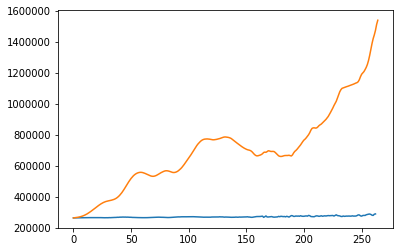

In [332]:
plt.plot(santa_dollars[0] + np.cumsum(santa_forecast))
plt.plot(zillow_df[95008].values);

In [326]:
santa_forecast[-1]

65.48773976605531

In [325]:
santa_dollars = np.cumsum(santa_forecast)+262100
#santa_dollars[0] = 262100

santa_dollars
# plt.plot(zillow_df[95008].values)

array([262165.4877111 , 262244.21367949, 262311.87149165, 262460.47660104,
       262527.41467212, 262717.48304635, 262730.6811418 , 263165.18696812,
       263177.32536257, 263224.65529323, 263462.10342497, 263578.19852398,
       263832.42025551, 263672.87335025, 264078.81566235, 263910.24942368,
       263977.83491297, 264168.66711107, 263902.32243234, 264429.7005004 ,
       263937.05766075, 264129.5026857 , 263856.98171999, 263900.68823185,
       263832.88578971, 263490.31858022, 263768.09359284, 263121.13957178,
       263437.64713075, 263414.83090679, 263218.20174915, 263939.02234661,
       263657.52232498, 264169.34473978, 264095.45454916, 264695.27094887,
       265126.88485596, 265197.32596323, 266165.06240989, 265806.48757289,
       266798.36218218, 266704.6973632 , 267073.28380406, 267681.71342995,
       267093.28589946, 267467.83940715, 266787.71262254, 267100.06959109,
       266529.88506981, 266112.45442978, 266154.72627172, 265312.66958648,
       265358.10095895, 2

In [277]:
zillow_df[95008]

Date_index
1996-04-01     262100.0
1996-05-01     263000.0
1996-06-01     264000.0
1996-07-01     265100.0
1996-08-01     266400.0
                ...    
2017-12-01    1421000.0
2018-01-01    1445700.0
2018-02-01    1474600.0
2018-03-01    1512900.0
2018-04-01    1539900.0
Name: 95008, Length: 265, dtype: float64

In [268]:
len(santadata), len(santa_forecast), len(zillow_df[95008])

(264, 300, 265)

In [ ]:
model = model_params['test_model']
model.plot_predict(1, 300,);

In [ ]:
model.plot_predict(1, 300)
plt.xlabel('Number of months')
plt.ylabel('Percentage return')
plt.show()

In [ ]:
model_two_df = zillow_cleandf[[94027, 90210, 94301, 33480, 94123]]
model_two_df.head()

In [ ]:
np.log(model_two_df).plot()
plt.ylabel('log_price');

In [ ]:
from model_builder import stationarity_test

In [ ]:
stationarity_test(model_two_df,'pct_change()')

In [ ]:
model_two = ARMA(model_two_df[94301].pct_change().dropna().values, (2,1)).fit()

In [ ]:
model_two.plot_predict(1, 300)
plt.xlabel('Number of months')
plt.ylabel('price difference every two months')
plt.show()